In [1]:
import fastText, keras
import math
import numpy as np 
from numpy import random
from random import sample
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras import *
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, mean_squared_error

Using TensorFlow backend.
/home1/zishan/anaconda3/envs/raghav_btp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
set_session(tf.Session(config=config))

In [3]:
ft = fastText.load_model("/home1/zishan/raghav/wiki.hi.bin")

nb_embedding_dims = ft.get_dimension()
nb_sequence_length = 75

In [4]:
def twitter_tokenizer(textline):
    textLine = re.sub(r'http\S+', 'URL', textline)
    textline = re.sub('@[\w_]+', 'USER_MENTION', textline)
    textline = re.sub('\|LBR\|', '', textline)
    textline = re.sub('\.\.\.+', '...', textline)
    textline = re.sub('!!+', '!!', textline)
    textline = re.sub('\?\?+', '??', textline)
    words = re.compile('[\U00010000-\U0010ffff]|[\w-]+|[^ \w\U00010000-\U0010ffff]+', re.UNICODE).findall(textline.strip())
    words = [w.strip() for w in words if w.strip() != '']
    return(words)

In [5]:
word_vectors_ft = {}
def process_features_crosslingual(textline, nb_sequence_length, nb_embedding_dims, tokenize=True, transmat = None):
    if not tokenize:
        words = textline.split()
    else:
        words = twitter_tokenizer(textline)
    features_ft = np.zeros((nb_sequence_length, nb_embedding_dims))
    features_idx = np.zeros(nb_sequence_length)
    max_words = min(len(words), nb_sequence_length)
    idx = nb_sequence_length - len(words[:max_words])
    for w in words[:max_words]:
        if w in word_vectors_ft:
            wv = word_vectors_ft[w]
        else:
            wv = ft.get_word_vector(w.lower())
            wv = np.matmul(wv, transmat) # applying transformation on the word vector to make the vector in same space
            word_vectors_ft[w] = wv
        features_ft[idx] = wv
        
        idx = idx + 1
    return features_ft

In [6]:
word_vectors_ft = {}
def process_features(textline, nb_sequence_length, nb_embedding_dims, tokenize=True):
    if not tokenize:
        words = textline.split()
    else:
        words = twitter_tokenizer(textline)
    features_ft = np.zeros((nb_sequence_length, nb_embedding_dims))
    features_idx = np.zeros(nb_sequence_length)
    max_words = min(len(words), nb_sequence_length)
    idx = nb_sequence_length - len(words[:max_words])
    for w in words[:max_words]:
        if w in word_vectors_ft:
            wv = word_vectors_ft[w]
        else:
            wv = ft.get_word_vector(w.lower())
            word_vectors_ft[w] = wv
        features_ft[idx] = wv
        
        idx = idx + 1
    return features_ft

In [28]:
def sequential_generator(filename, 
                         batch_size, 
                         labels2Idx:'dict to make output labels',
                         check:'to check if all lines in file are of same length.To check enter the len of line after splitting it by tabs' = None,
                         tokenize:'specify if using twitter tokenzor to preprocess lines'=False, 
                         crosslingual:'specify if crosslingual training being done'= False, 
                         transmat= None
                        ):    
    
    f = open(filename)
    n_labels = len(labels2Idx)
    while True:
        batch_features_ft = np.zeros((batch_size, nb_sequence_length, nb_embedding_dims))
        batch_labels = np.zeros((batch_size, len(labels2Idx)))
        batch_intensity = np.zeros((batch_size, 1))
        for i in range(batch_size):
            line = f.readline()
            if ("" == line):
                f.seek(0)
                line = f.readline()
            data = line.strip().split('\t')
            if check:
                if len(data)!=check:
                    i-=1
                    continue
            if not crosslingual:
                batch_features_ft[i] = process_features(data[0], nb_sequence_length, nb_embedding_dims, tokenize= tokenize)
            else:
                batch_features_ft[i] = process_features_crosslingual(data[0], nb_sequence_length, nb_embedding_dims, tokenize, transmat)
            batch_labels[i] = to_categorical(labels2Idx[data[1]], n_labels)
            batch_intensity[i] = float(data[2])
        yield ([batch_features_ft], [batch_labels, batch_intensity])

In [8]:
def train_dev_sentences(filetrain, filedev, check:'to check if lines of file are all same lenght after separating by tab'):
    labels2Idx = {}
    train_lines = [line.strip().split("\t") for line in open(filetrain) if len(line.split('\t'))==check]
    dev_lines = [line.strip().split("\t") for line in open(filedev) if len(line.strip().split('\t'))==check]
    for dataset in [train_lines, dev_lines]:
        for line in dataset:
            label = line[1]
            if label not in labels2Idx.keys():
                labels2Idx[label]= len(labels2Idx)
    train_sentences =[]
    train_labels = []
    dev_sentences = []
    dev_labels = []
    try:
        for line_no, x in enumerate(train_lines):
            train_sentences.append(x[0])
            train_labels.append([labels2Idx[x[1]], float(x[2])])
    except Exception as e:
        print(x, line_no, end='\n\n')
    try:
        for line_no, x in enumerate(dev_lines):
            dev_sentences.append(x[0])
            dev_labels.append([labels2Idx[x[1]], float(x[2])])
    except Exception as e:
        print(x, line_no)
    return (train_sentences, train_labels, dev_sentences, dev_labels, labels2Idx)

In [9]:
train_file = '/home1/zishan/raghav/Data/train_with_intensity.txt'
dev_file = '/home1/zishan/raghav/Data/dev_with_intensity.txt'
train_sentences, train_labels, dev_sentences, dev_labels, labels2Idx = train_dev_sentences(train_file, dev_file, 3)

In [10]:
n_words = 0
for sentence in train_sentences:
    n_words+=len(sentence)
print(n_words)

111978


In [11]:
from collections import Counter
print(Counter([x[0] for x in train_labels]))
print(labels2Idx)

Counter({0: 389, 2: 191, 4: 146, 5: 146, 1: 119, 3: 85, 6: 61, 7: 47, 8: 19})
{'SADNESS': 0, 'FEAR/ANXIETY': 1, 'SYMPATHY/PENSIVENESS': 2, 'JOY': 3, 'OPTIMISM': 4, 'NO-EMOTION': 5, 'DISGUST': 6, 'ANGER': 7, 'SURPRISE': 8}


In [12]:
print(train_sentences[:2])
print(train_labels[:10])
print(labels2Idx)
print(len(train_labels))

['आतंंकवादियों ने सुबह करीब सवा छह बजे पीछे से 3-1 गोरखा राइफल्स के शिविर को निशाना बनाते हुए अंधाधुंध गोलीबारी की जिसमें एक आम नागरिक की मौत हो गई जबकि एक जवान घायल हो गया।', 'दक्षिण अफ्रीका के डरबन शहर में गुरुवार को कुछ अज्ञात हमलावरों ने एक मस्जिद पर हमला कर मस्जिद के इमाम की हत्या कर दी और 2 अन्य लोगों को चाकू घोंपकर घायल कर दिया।']
[[0, 0.4], [0, 0.3], [1, 0.4], [2, 0.6], [0, 0.8], [3, 0.3], [0, 1.0], [4, 0.3], [4, 0.5], [1, 0.4]]
{'SADNESS': 0, 'FEAR/ANXIETY': 1, 'SYMPATHY/PENSIVENESS': 2, 'JOY': 3, 'OPTIMISM': 4, 'NO-EMOTION': 5, 'DISGUST': 6, 'ANGER': 7, 'SURPRISE': 8}
1203


In [13]:
n_labels = len(labels2Idx)

In [14]:
def compile_model_bilstm_cnn(no_labels:'total labels for classification'):
    model_input_embedding = Input(shape = (nb_sequence_length, nb_embedding_dims))
    lstm_block = Bidirectional(LSTM(100, dropout = 0.5, return_sequences=True))(model_input_embedding)
    lstm_block = LeakyReLU()(lstm_block)

    filter_sizes = (3, 4, 5)
    conv_blocks = []
    for sz in filter_sizes:
        conv = Conv1D(
            filters = 200,
            kernel_size = sz,
            padding = 'valid',
            strides = 1
        )(lstm_block)
        conv = LeakyReLU()(conv)
        conv = GlobalMaxPooling1D()(conv)
        conv = Dropout(0.5)(conv)
        conv_blocks.append(conv)
    model_concatenated = concatenate([conv_blocks[0], conv_blocks[1], conv_blocks[2]])
    model_concatenated = Dense(100)(model_concatenated)
    model_concatenated = LeakyReLU(name='final_relu')(model_concatenated)
    model_output_classification = Dense(no_labels, activation = "softmax", name='for_classification')(model_concatenated)
#     model_output_intensity = Dense(1, activation = "sigmoid", name='for_intensity')(model_concatenated)
#     new_model = Model(model_input_embedding, [model_output_classification, model_output_intensity])
    new_model = Model(model_input_embedding, model_output_classification)
    
    new_model.compile(loss=['categorical_crossentropy'], optimizer='nadam', metrics = ['accuracy'])
    new_model.summary()
    return new_model

In [32]:
def compile_model_with_intensity(no_old_labels, old_weights_file):
    model = compile_model_bilstm_cnn(no_labels=no_old_labels)
    model.load_weights(old_weights_file)
    temp = model.get_layer('final_relu').output
    dense_intensity = Dense(1, activation='sigmoid', name='intensity')(temp)
    print(dense_intensity)
    new_model = Model(inputs=model.input, outputs=[model.output, dense_intensity])
    for layer in new_model.layers:
        print(layer.name)
    new_model.compile(loss=['categorical_crossentropy','mean_absolute_error'], optimizer='nadam', metrics=['accuracy'], loss_weights=[0.0,1.0])
    new_model.summary()
#     keras.utils.plot_model(new_model, to_file='/home1/zishan/raghav/image.png')
    for layer in new_model.layers:
        if layer.name is not 'intensity':
            layer.trainable = False
    for layer in new_model.layers:
        print(layer.name, layer.trainable)
    new_model.compile(loss=['categorical_crossentropy','mean_absolute_error'], optimizer='nadam', metrics=['accuracy'], loss_weights=[0.0,1.0])

    return new_model
    

In [34]:
no_old_labels = len(labels2Idx)
old_weights_file = '/home1/zishan/raghav/weights/tl_semeval_gradual_unfreeze.h5'
new_model = compile_model_with_intensity(no_old_labels=no_old_labels, old_weights_file= old_weights_file)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 75, 300)      0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 75, 200)      320800      input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 75, 200)      0           bidirectional_6[0][0]            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 73, 200)      120200      leaky_re_lu_21[0][0]             
__________________________________________________________________________________________________
conv1d_17 

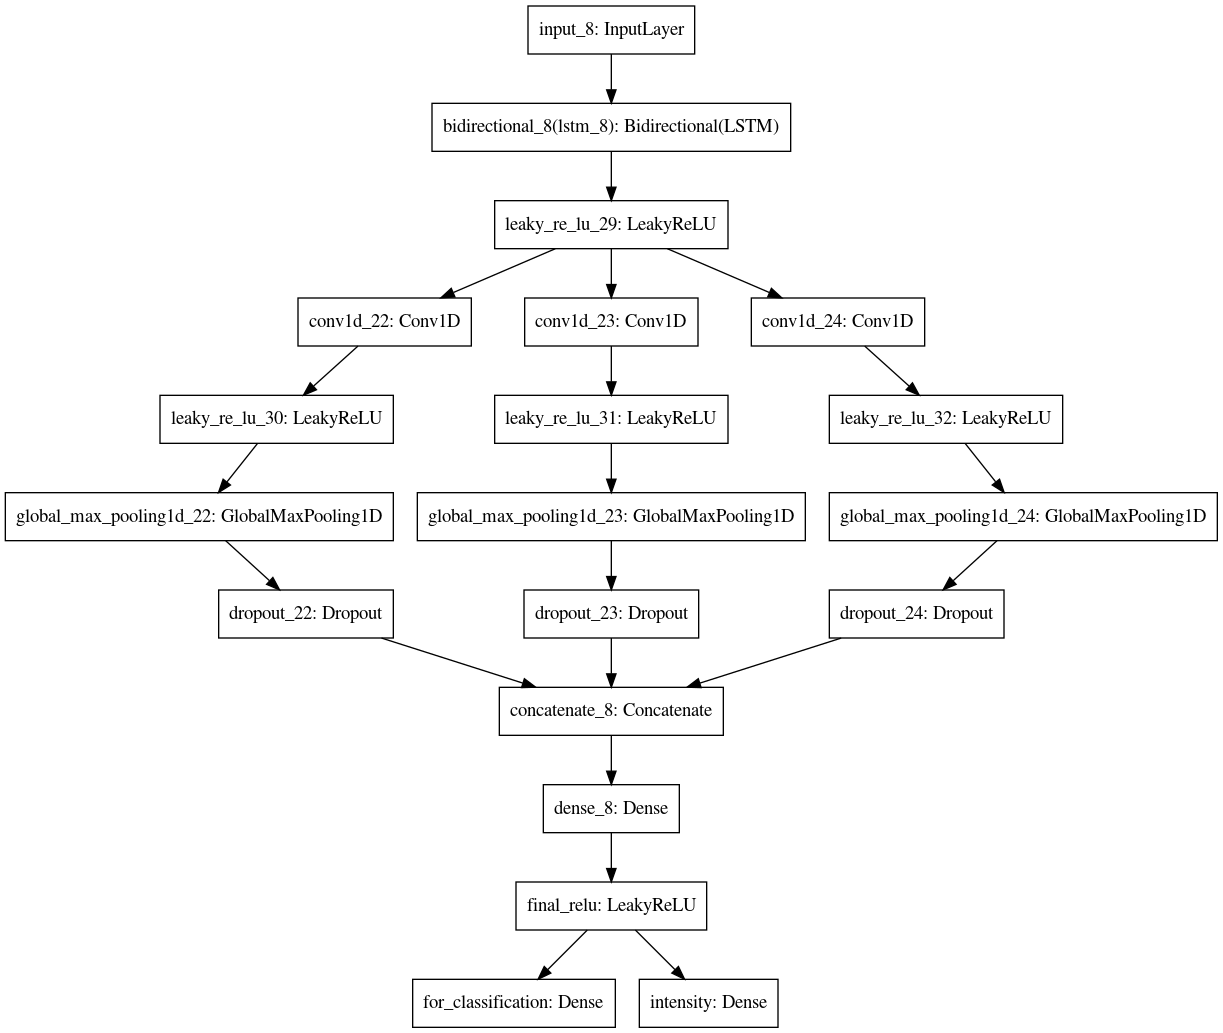

In [35]:
from IPython.display import Image
Image("/home1/zishan/raghav/image.png")

In [36]:
transmat = np.loadtxt('/home1/zishan/raghav/fastText_multilingual/alignment_matrices/hi.txt')
generator = sequential_generator(filename=train_file, batch_size=len(train_sentences), labels2Idx=labels2Idx, crosslingual=True, transmat=transmat)
x,y = generator.__next__()

In [37]:
print(x[0].shape)
print(y[0].shape)
print(y[1].shape)

(1203, 75, 300)
(1203, 9)
(1203, 1)


In [38]:
def get_logs_and_weights(epochs, filename_to_log, weights_file, no_labels, model, transmat=None, crosslingual=False, tokenize=True):
    for layer in model.layers:
        print(layer.name, layer.trainable)
    min_mse = math.inf
    f = open(filename_to_log,'w')
    f.close()
    for epoch in range(200):
        print("Epoch {}".format(epoch))
        model.fit(x, y, epochs=1)

        testset_features = np.zeros((len(dev_sentences), nb_sequence_length, nb_embedding_dims))
        for i in range(len(dev_sentences)):
            if crosslingual:
                testset_features[i] = process_features_crosslingual(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize, transmat)
            else:
                testset_features[i] = process_features(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize)
        results = model.predict(testset_features)
        class_pred = results[0].argmax(axis=1)
        intensity_pred =[i.tolist()[0] for i in results[1]]
        true_classes= [label[0] for label in dev_labels]
        true_intensity = [label[1] for label in dev_labels]
        mse = mean_squared_error(true_intensity, intensity_pred)
        correlation_coeff = np.corrcoef(true_intensity, intensity_pred)[0,1]
        f1 = f1_score(true_classes, class_pred, average='macro')
        if min_mse> mse:
            print("saved!")
            min_mse = mse
            model.save_weights(weights_file)
            with open(filename_to_log,'a+') as f:
                text = "epoch:{0} f1:{1} mse:{2} correlation_coeff:{3}\n".format(epoch, f1, mse, correlation_coeff)
                f.write(text)

        print("f1:{0} mse:{1} correlation_coeff:{2}".format(f1, mse, correlation_coeff))


In [39]:
epochs =200
filename_to_log = '/home1/zishan/raghav/logs/tl_semeval_gradual_unfreeze_with_intensity.txt'
weights_file = '/home1/zishan/raghav/weights/tl_semeval_gradual_unfreeze_with_intensity.h5'
transmat = np.loadtxt('/home1/zishan/raghav/fastText_multilingual/alignment_matrices/hi.txt')
crosslingual=True
tokenize = True
no_labels = len(labels2Idx)
model = new_model
get_logs_and_weights(epochs=epochs, filename_to_log=filename_to_log,
                     weights_file=weights_file, no_labels=no_labels,
                     model= model, transmat = transmat, crosslingual=crosslingual, tokenize = True)

input_6 False
bidirectional_6 False
leaky_re_lu_21 False
conv1d_16 False
conv1d_17 False
conv1d_18 False
leaky_re_lu_22 False
leaky_re_lu_23 False
leaky_re_lu_24 False
global_max_pooling1d_16 False
global_max_pooling1d_17 False
global_max_pooling1d_18 False
dropout_16 False
dropout_17 False
dropout_18 False
concatenate_6 False
dense_6 False
final_relu False
for_classification False
intensity True
Epoch 0
Epoch 1/1
1203/1203 [==============================] - 5s 4ms/step - loss: 0.4471 - for_classification_loss: 10.5484 - intensity_loss: 0.4471 - for_classification_acc: 0.1962 - intensity_acc: 0.0673


/home1/zishan/anaconda3/envs/raghav_btp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


saved!
f1:0.0604825226071304 mse:0.14316128079298804 correlation_coeff:0.0222059028737879
Epoch 1
Epoch 1/1
1203/1203 [==============================] - 4s 3ms/step - loss: 0.4306 - for_classification_loss: 10.6072 - intensity_loss: 0.4306 - for_classification_acc: 0.1704 - intensity_acc: 0.0906
f1:0.0604825226071304 mse:0.17097700299467186 correlation_coeff:0.0017265881795558032
Epoch 2
Epoch 1/1
 832/1203 [===================>..........] - ETA: 1s - loss: 0.4314 - for_classification_loss: 10.1576 - intensity_loss: 0.4314 - for_classification_acc: 0.2043 - intensity_acc: 0.0805

KeyboardInterrupt: 

# check


In [40]:
def train_dev_sentences_without_intensity(filetrain, filedev, check:'to check if lines of file are all same lenght after separating by tab'):
    labels2Idx = {}
    train_lines = [line.strip().split("\t") for line in open(filetrain) if len(line.split('\t'))==check]
    dev_lines = [line.strip().split("\t") for line in open(filedev) if len(line.strip().split('\t'))==check]
    train_sentences = [x[0] for x in train_lines]
    for dataset in [train_lines, dev_lines]:
        for line in dataset:
            label = line[1]
            if label not in labels2Idx.keys():
                labels2Idx[label]= len(labels2Idx)
                
    train_labels = [labels2Idx[x[1]] for x in train_lines]
    dev_sentences = [x[0] for x in dev_lines]
    dev_labels = [labels2Idx[x[1]] for x in dev_lines]
    return (train_sentences, train_labels, dev_sentences, dev_labels, labels2Idx)

In [45]:
train_file = '/home1/zishan/raghav/Data/train.txt'
dev_file = '/home1/zishan/raghav/Data/dev.txt'
train_sentences, train_labels, dev_sentences, dev_labels, labels2Idx = train_dev_sentences_without_intensity(train_file, dev_file, 2)

In [47]:
model = compile_model_bilstm_cnn(len(labels2Idx))
model.load_weights('/home1/zishan/raghav/weights/tl_crowdflower_suf_td.h5')
transmat = np.loadtxt('/home1/zishan/raghav/fastText_multilingual/alignment_matrices/hi.txt')
testset_features = np.zeros((len(dev_sentences), nb_sequence_length, nb_embedding_dims))
for i in range(len(dev_sentences)):
    testset_features[i] = process_features_crosslingual(dev_sentences[i], nb_sequence_length, nb_embedding_dims,True, transmat)
results = model.predict(testset_features)

predLabels = results.argmax(axis=-1)
print(len(dev_labels))
devLabels = dev_labels
f1 = f1_score(devLabels, predLabels, average='macro') # offen
print(f1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 75, 300)      0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 75, 200)      320800      input_11[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 75, 200)      0           bidirectional_11[0][0]           
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 73, 200)      120200      leaky_re_lu_41[0][0]             
__________________________________________________________________________________________________
conv1d_32 

/home1/zishan/anaconda3/envs/raghav_btp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(train_sentences[:2])
print(train_labels[:2])

In [ ]:
n_labels = len(labels2Idx)
batch_features_ft = np.zeros((len(train_sentences), nb_sequence_length, nb_embedding_dims))
batch_labels = np.zeros((len(train_sentences), len(labels2Idx)))
batch_intensity = np.zeros((len(train_sentences), 1))
for i in range(len(train_sentences)):
    line = train_sentences[i]
    label = train_labels[i][0]
    intensity = train_labels[i][1]
#     if ("" == line):
#         f.seek(0)
#         line = f.readline()
    data = line.strip().split('\t')
#     if check:
#         if len(data)!=check:
#             i-=1
#             continue
    batch_features_ft[i] = process_features(line, nb_sequence_length, nb_embedding_dims, tokenize= tokenize)
    batch_labels[i] = to_categorical(label, n_labels)
    batch_intensity[i] = float(intensity)
x, y = ([batch_features_ft], [batch_labels, batch_intensity]) 

In [ ]:
print(x[0].shape)
print(y[0].shape)
print(y[1].shape)

In [ ]:
def get_logs_and_weights(x, y, epochs, filename_to_log, weights_file, no_labels, model, transmat=None, crosslingual=False, tokenize=True):
    for layer in model.layers:
        print(layer.name, layer.trainable)
    min_mse = math.inf
    f = open(filename_to_log,'w')
    f.close()
    testset_features = np.zeros((len(dev_sentences), nb_sequence_length, nb_embedding_dims))
    for i in range(len(dev_sentences)):
        if crosslingual:
            testset_features[i] = process_features_crosslingual(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize, transmat)
        else:
            testset_features[i] = process_features(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize)
    results = model.predict(testset_features)
    class_pred = results[0].argmax(axis=1)
    intensity_pred =[i.tolist()[0] for i in results[1]]
    true_classes= [label[0] for label in dev_labels]
    true_intensity = [label[1] for label in dev_labels]
    mse = mean_squared_error(true_intensity, intensity_pred)
    correlation_coeff = np.corrcoef(true_intensity, intensity_pred)[0,1]
    print(len(true_classes))
    f1 = f1_score(true_classes, class_pred, average='macro')
    print(f1)
    for epoch in range(200):
        print("Epoch {}".format(epoch))
        model.fit(x, y, epochs=1)

        testset_features = np.zeros((len(dev_sentences), nb_sequence_length, nb_embedding_dims))
        for i in range(len(dev_sentences)):
            if crosslingual:
                testset_features[i] = process_features_crosslingual(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize, transmat)
            else:
                testset_features[i] = process_features(dev_sentences[i], nb_sequence_length, nb_embedding_dims, tokenize)
        results = model.predict(testset_features)
        class_pred = results[0].argmax(axis=1)
        intensity_pred =[i.tolist()[0] for i in results[1]]
        true_classes= [label[0] for label in dev_labels]
        true_intensity = [label[1] for label in dev_labels]
        mse = mean_squared_error(true_intensity, intensity_pred)
        correlation_coeff = np.corrcoef(true_intensity, intensity_pred)[0,1]
        f1 = f1_score(true_classes, class_pred, average='macro')
        if min_mse> mse:
            print("saved!")
            min_mse = mse
            model.save_weights(weights_file)
            with open(filename_to_log,'a+') as f:
                text = "epoch:{0} f1:{1} mse:{2} correlation_coeff:{3}\n".format(epoch, f1, mse, correlation_coeff)
                f.write(text)

        print("f1:{0} mse:{1} correlation_coeff:{2}".format(f1, mse, correlation_coeff))


In [ ]:
new_model = compile_model_with_intensity(len(labels2Idx), '/home1/zishan/raghav/weights/tl_hindi_sentiments_suf_bu.h5')

In [ ]:
epochs =200
filename_to_log = '/home1/zishan/raghav/logs/tl_hindi_sentiments_suf_bu_with_intensity.txt'
weights_file = '/home1/zishan/raghav/weights/tl_hindi_setiments_suf_bu_with_intensity.h5'
transmat = np.loadtxt('/home1/zishan/raghav/fastText_multilingual/alignment_matrices/hi.txt')
crosslingual=False
tokenize = True
no_labels = len(labels2Idx)
model = new_model
x = x
y = y
get_logs_and_weights(x, y, epochs=epochs, filename_to_log=filename_to_log,
                     weights_file=weights_file, no_labels=no_labels,
                     model= model, transmat = transmat, crosslingual=crosslingual, tokenize = True)